In [125]:
from pathlib import Path 
import re

import pyogrio
import geopandas as gpd
import pandas as pd
from global_hydrography.preprocess import TDXPreprocessor
from global_hydrography.delineation.mnsi import modified_nest_set_index
import shapely
import shapely.plotting

In [126]:
# define a helper function for the operation
def compute_mnsi(file:Path, preprocessor:TDXPreprocessor) -> gpd.GeoDataFrame:

    #parse the file name to get the HDX Basin Id
    tdx_basin_id = int(re.search("\d*",file.name).group(0))

    #open the file as GeoDataFrame
    gdf = pyogrio.read_dataframe(file, use_arrow=True)
    info = pyogrio.read_info(file)

    #apply preprocessing to make linkno globally unique
    gdf = preprocessor.tdx_to_global_linkno(gdf, tdx_basin_id)

    #compute the modified nested set index
    gdf = modified_nest_set_index(gdf)
    return gdf

In [127]:
#read and preprocess the files
root_path = "..\data_temp"
region_no = 2020057170
file_streamnet = Path(root_path + f"\{region_no}-streamnet.gpkg")
file_basin = Path(root_path + f"\{region_no}-basins.gpkg")

preprocessor = TDXPreprocessor()

gdf_streamnet = compute_mnsi(file_streamnet, preprocessor)
gdf_basin = pyogrio.read_dataframe(file_basin, read_geometry=True, use_arrow=True)
gdf_basins = preprocessor.tdx_to_global_linkno(gdf_basin, region_no )

In [128]:
gdf_streamnet[[*MSNI_FIELDS]]

,ROOT_ID,DISCOVER_TIME,FINISH_TIME
0,270000001,1,2
1,270000161,1,2
2,270000321,1,2
3,270000002,1,2
4,270000162,1,2
...,...,...,...
10892,270002236,3,10
10893,270004795,1,14
10894,270002556,5,16
10895,270002716,3,24


In [129]:
# we talked about migrating the nested set information over to the basins layer for this operation.
# That would make it so we only needed to load a single file instead of both basins and streamnet
# Other team will do this more elegantly, but this is a quick and dirty join
gdf_basin = gdf_basin.set_index("streamID")
gdf_streamnet = gdf_streamnet.set_index("LINKNO")
MSNI_FIELDS = ('ROOT_ID','DISCOVER_TIME','FINISH_TIME',)
gdf = gdf_basin.join(gdf_streamnet[[*MSNI_FIELDS]])

In [130]:
# we want to identify the worse case scenario for combination
# this would likely be the most possibly elements 
# Though there may be a case to be made about complicate geometries verse total number
# either way this is a start
linkid = gdf.loc[(gdf['FINISH_TIME'] == gdf['FINISH_TIME'].max()),'ROOT_ID'].max()

#note for production this link_no will be supplied as an input


In [131]:
gdf.loc[linkid]

geometry         POLYGON ((-16.603202852714546 66.0992690298479...
ROOT_ID                                                  270025224
DISCOVER_TIME                                                    1
FINISH_TIME                                                    858
Name: 270025224, dtype: object

In [132]:
def subset_network(gdf:gpd.GeoDataFrame, linkid:int) -> gpd.GeoDataFrame:
    """Subset a basins (gdf) to include only elements upstream of linkid 
    
    Args:
        gdf (gpd.GeoDataFrame): and GeoDataFrame representation of the 
            basins dataset where the stream reach with linkid resides.
        linkid (int): The global unique identifier for the stream 
            network of interest

    Returns:
        gpd.GeoDataFrame: Subsetted GeoDataFrame containing all basins
            upstream of the basin corresponding to linkno  
    """
    #ID target basins from linkno and extract critical mnsi info
    #this is assuming the gdf has already set index to streamID
    target_basin = gdf.loc[linkid]
    root_id = target_basin['ROOT_ID']
    discover_time = target_basin['DISCOVER_TIME']
    finish_time = target_basin['FINISH_TIME']

    #subset using modified nest set index logic, further documented in README
    return gdf.loc[
        (gdf['ROOT_ID'] == root_id)
        & (gdf['DISCOVER_TIME'] >= discover_time)
        & (gdf['FINISH_TIME'] <= finish_time)
    ]

In [172]:
print(gdf.shape)
sub_gdf = subset_network(gdf_dissolved,linkid)
print(sub_gdf.shape)

(10895, 4)
(187, 5)


# There are a few ways we can combine geometries let's look at some

In [173]:
# helper function to validate resultant polygon 
def validate_polygon(polygon:shapely.Geometry) -> None:
    print(shapely.area(polygon))
    shapely.plotting.plot_polygon(polygon)

## Naive/Brute Force Solutions  

### Native GeoDataFrame

**Pros**

Easier to implement, it's already provided by the library

**Cons** 

Performance is a little rough. ~12 seconds for ~850 polygons in test dataset 

Performance 

In [174]:
%%time
combined = sub_gdf.dissolve()
polygon = combined['geometry'][0]

CPU times: total: 1.06 s
Wall time: 4.56 s


1.3297438999850995


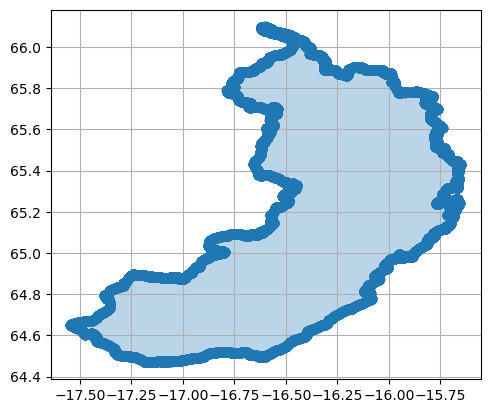

In [138]:
validate_polygon(polygon)

In [139]:
%%time
combined = new_sub.dissolve()
polygon = combined['geometry'][0]

CPU times: total: 266 ms
Wall time: 517 ms


0.07057458039022647


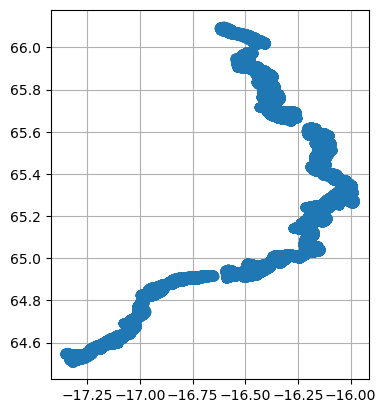

In [140]:
validate_polygon(polygon)

### Shapely unary_union
** Pros **

* Easy to implement

**Cons**

* Converts out of geopandas space - likely a performance hit (due to conversion)
* Relatively slow as well.  Not really doing anything different that GeoPandas  


In [141]:
%%time
polygon = shapely.unary_union(sub_gdf['geometry'])

CPU times: total: 3.81 s
Wall time: 11 s


1.3297438999850955


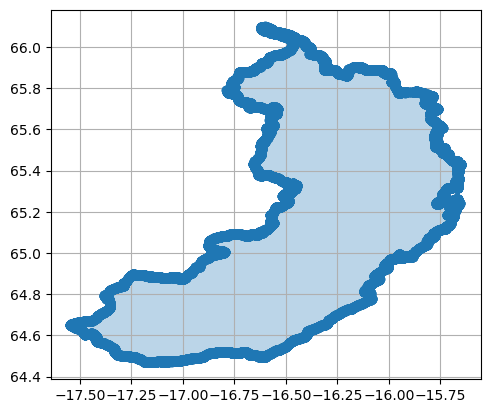

In [142]:
validate_polygon(polygon)

## Alternative Approaches

### Pre-dissolve polygons 

**Summary**

The naive solution is just throwing an array of geometries into the dissolve algorithm. 
What if we pre-dissolve some of those upstream geometries into a larger polygon.
Then the final dissolve process will involve fewer polygons  

**Pros**
* Will be faster because we have less polygons to dissolve for the final step
* Can pre-dissolve polygons up front 

**Cons**
* More complex to implement, we need logic to filter out polygons already accounted for in the 
    pre-dissolved polygons
* More space complexity, both in terms of in memory (holding a second set of polygons) and drive
    space as we need to store a second set of polygons

#### Step 0 - Proof of concept

Does pre-dissolving polygons actually result in a speed up, 
or is polygon size driver performance more than polygon count? 

In [ ]:
#lets pre-dissolve the sub_gdf into chunks of 100
polygons = []
step = 100
sub_gdf = sub_gdf.sort_values(['FINISH_TIME'])
for i in range(0, sub_gdf.shape[0],step):
    print(i)
    new_sub = sub_gdf.iloc[i:i+step]
    combined = new_sub.dissolve()
    polygon = combined['geometry'][0]
    polygons.append(polygon)


In [ ]:
len(polygons)
for polygon in polygons:
    shapely.plotting.plot_polygon(polygon)

Now let's see what the runtime looks like

In [ ]:
%%time
polygon = shapely.unary_union(polygons)

In [ ]:
validate_polygon(polygon)

#### Step 1 - pre-dissolve polygons
We need to develop logic to pre-dissolve polygons.
The pre-dissolved polygons should also be meaningful in 
that they utilize the DISCOVER_TIME and FINAL_TIME parameters
to ensure that we can easily identify polygons that are upstream
and deselect them

In [177]:
def pre_dissolve_polygons(gdf:gpd.GeoDataFrame, max_elements:int=50, min_elements:int=3) -> gpd.GeoDataFrame:
    if min_elements < 2:
        raise ValueError('min_elements needs to be greater than two.')

    #we are going to be mutating the dataframe, so let's make a copy
    gdf = gdf.copy(deep=True)
    
    #identify add nodes where upstream element count is more than 
    gdf['ELEMENT_COUNT'] = (gdf['FINISH_TIME'] - gdf['DISCOVER_TIME']) #TODO: confirm if we need the `/ 2` here to get accurate count

    # our stop condition is that upstream with less than max_elements have been combined
    while gdf.loc[(gdf["ELEMENT_COUNT"] <= max_elements),'ELEMENT_COUNT'].max() > min_elements:
        #find the element with the largest element count still above the processing threshold
        df = gdf.loc[ (gdf['ELEMENT_COUNT'] <= max_elements)]
        element = df.sort_values(["ELEMENT_COUNT"], ascending=False).iloc[0]
        #dissolve the polygon 
        gdf = __dissolve_polygon(gdf, element.name )
    return gdf

def __dissolve_polygon(gdf:gpd.GeoDataFrame, linkid:int) -> gpd.GeoDataFrame:
    """Dissolves polygons upstream of linkid and places them in gdf """

    #subset based on element for pre-dissolve
    sub = subset_network(gdf, linkid)

    #create the pre-dissolved row
    dissolved_row = sub.dissolve()

    #update upstream element count to indicate this has been processed
    dissolved_row['ELEMENT_COUNT'] = 1

    #get id's for the rows that are now represented by a dissolved polygon
    elements = sub.index

    #drop elements 
    gdf.drop(elements, inplace=True)
    
    #add in pre-dissolved row
    gdf = pd.concat([gdf, dissolved_row])

    return gdf




gdf_dissolved = pre_dissolve_polygons(gdf, max_elements=100)

270033573 with elements count of 99
(98, 5)
(98,)
Combined upstream. New dataframe dimensions are (10798, 5)
270027824 with elements count of 99
(99, 5)
(99,)
Combined upstream. New dataframe dimensions are (10700, 5)
270034855 with elements count of 99
(99, 5)
(99,)
Combined upstream. New dataframe dimensions are (10602, 5)
270017589 with elements count of 99
(99, 5)
(99,)
Combined upstream. New dataframe dimensions are (10504, 5)
270038993 with elements count of 99
(99, 5)
(99,)
Combined upstream. New dataframe dimensions are (10406, 5)
270043006 with elements count of 99
(99, 5)
(99,)
Combined upstream. New dataframe dimensions are (10308, 5)
270028945 with elements count of 99
(99, 5)
(99,)
Combined upstream. New dataframe dimensions are (10210, 5)
270036284 with elements count of 97
(97, 5)
(97,)
Combined upstream. New dataframe dimensions are (10114, 5)
270039793 with elements count of 97
(97, 5)
(97,)
Combined upstream. New dataframe dimensions are (10018, 5)
270035801 with elem

#### step 2 - verify dissolved with subset is more performant 
The runtime appears to be about 4x faster than using the raw polygons alone


In [179]:
print(gdf_dissolved.shape)
sub_gdf_dissolved = subset_network(gdf_dissolved,linkid)
print(sub_gdf_dissolved.shape) 

(2165, 5)
(133, 5)


In [181]:
%%time
combined = sub_gdf_dissolved.dissolve()
polygon = combined['geometry'][0]

CPU times: total: 1 s
Wall time: 3.06 s
